In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**EDA**

In [ ]:

import numpy as np
import pandas as pd       
import os 
import math 

import matplotlib.pyplot as plt  
import IPython.display as ipd  # To play sound in the notebook
import librosa
import librosa.display
from tqdm import *
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [ ]:
os.chdir("drive/My Drive/Accent_Recognition")

In [ ]:
fname_f = 'recordings/' + 'english385.mp3'   
ipd.Audio(fname_f)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


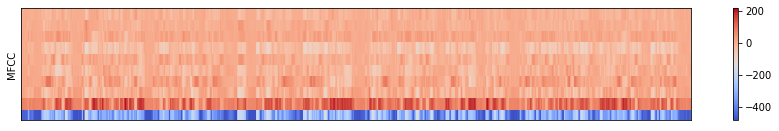

In [ ]:
fname_f = 'recordings/' + 'english385.mp3'

data, sample_rate = librosa.load(fname_f)# Chop audio at 10 secs...
mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc = 10)# 10 MFCC components

plt.figure(figsize=(15, 7))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc)
plt.ylabel('MFCC')
plt.colorbar()


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


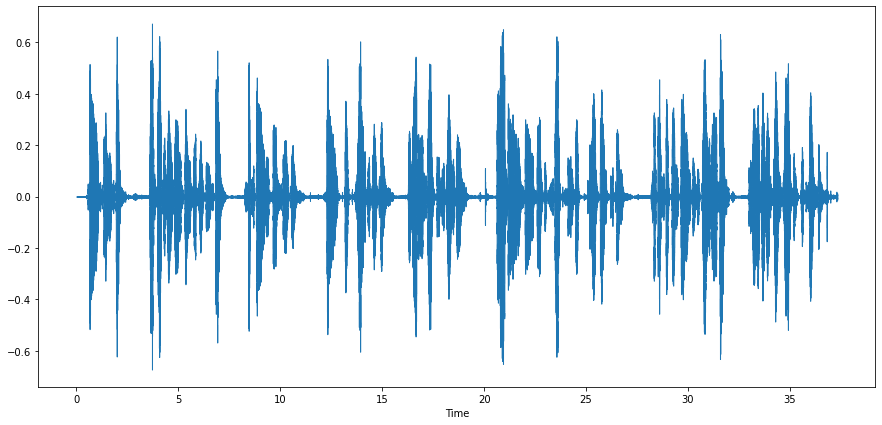

In [ ]:
fname_m = 'recordings/' + 'english381.mp3' 
ipd.Audio(fname_m)

data,sample_rate=librosa.load(fname_m)
mfcc=librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13)

plt.figure(figsize=(15,7))

librosa.display.waveshow(data,sr=sample_rate)

ipd.Audio(fname_m)



In [ ]:
data

array([ 3.5619607e-05,  1.8985076e-05,  2.9440562e-05, ...,
        2.4599645e-03,  1.6011774e-03, -1.8820003e-05], dtype=float32)

In [ ]:
sample_rate

22050

In [ ]:
rdata=pd.read_csv('speakers_all.csv')
rdata.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,24.0,12.0,"koussi, senegal",balanta,balanta,male,788,senegal,True,NaN,NaN,NaN
1,18.0,10.0,"buea, cameroon",cameroon,cameroon,male,1953,cameroon,True,NaN,NaN,NaN
2,48.0,8.0,"hong, adamawa, nigeria",fulfulde,fulfulde,male,1037,nigeria,True,NaN,NaN,NaN
3,42.0,42.0,"port-au-prince, haiti",haitian,haitian,male,1165,haiti,True,NaN,NaN,NaN
4,40.0,35.0,"port-au-prince, haiti",haitian,haitian,male,1166,haiti,True,NaN,NaN,NaN


In [ ]:
len(rdata['native_language'].unique())


214

In [ ]:
rdata[rdata['native_language']=='english']


,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,Unnamed: 9,Unnamed: 10,Unnamed: 11
363,42.0,0.0,"pittsburgh, pennsylvania, usa",english1,english,male,61,usa,False,NaN,NaN,NaN
364,35.0,0.0,"davenport, iowa, usa",english10,english,female,62,usa,False,NaN,NaN,NaN
365,23.0,0.0,"miami, florida, usa",english100,english,female,63,usa,False,NaN,NaN,NaN
366,18.0,0.0,"toronto, ontario, canada",english101,english,female,64,canada,False,NaN,NaN,NaN
367,22.0,0.0,"torrington, connecticut, usa",english102,english,male,65,usa,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
937,18.0,0.0,"mishawaka, indiana, usa",english95,english,male,160,usa,False,NaN,NaN,NaN
938,31.0,0.0,"point pleasant, new jersey, usa",english96,english,male,161,usa,False,NaN,NaN,NaN
939,42.0,0.0,"wilmington nc, north carolina, usa",english97,english,male,162,usa,False,NaN,NaN,NaN
940,22.0,0.0,"spokane, washington, usa",english98,english,male,163,usa,False,NaN,NaN,NaN


In [ ]:
rdata[rdata['file_missing?']=='True'].count()

age                0
age_onset          0
birthplace         0
filename           0
native_language    0
sex                0
speakerid          0
country            0
file_missing?      0
Unnamed: 9         0
Unnamed: 10        0
Unnamed: 11        0
dtype: int64

In [ ]:
rdata['sex'].value_counts()

male      1123
female    1048
famale       1
Name: sex, dtype: int64

In [ ]:
res=rdata['native_language'].value_counts()
print(res)

english     579
spanish     162
arabic      102
mandarin     65
french       63
           ... 
kalanga       1
kabyle        1
jola          1
irish         1
zulu          1
Name: native_language, Length: 214, dtype: int64


In [ ]:
res1=rdata[rdata['native_language']!='english'].native_language.value_counts()


In [ ]:
res1[res>40].sum()

587

**Preprocessing**

In [ ]:
metadata=rdata.groupby("native_language").filter(lambda x: len(x) >40)

In [ ]:
#for test
test_data = rdata.groupby("native_language").filter(lambda x: len(x) <40)

In [ ]:
metadata.sex.value_counts()

male      612
female    554
Name: sex, dtype: int64

In [ ]:
metadata['native_language'].value_counts()

english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
Name: native_language, dtype: int64

In [ ]:
rdata.shape

(2172, 12)

In [ ]:
metadata.shape #almost half of the original data

(1166, 12)

In [ ]:
metadata.drop(columns=['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'],inplace=True)

In [ ]:
metadata.head()


,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?
70,38.0,12.0,"riyadh, saudi arabia",arabic1,arabic,female,11,saudi arabia,False
71,26.0,5.0,"cairo, egypt",arabic10,arabic,male,12,egypt,False
72,40.0,10.0,"beirut, lebanon",arabic100,arabic,female,2159,lebanon,False
73,21.0,10.0,"doha, qatar",arabic101,arabic,male,2160,qatar,False
74,22.0,3.0,"jiddah, saudi arabia",arabic102,arabic,male,2161,saudi arabia,False


In [ ]:
metadata['accent'] = metadata['native_language'].apply(lambda x: 'native' if x=='english' else 'non-native')

In [ ]:
metadata.head()

,age,age_onset,birthplace,filename,native_language,sex,speakerid,country,file_missing?,accent
70,38.0,12.0,"riyadh, saudi arabia",arabic1,arabic,female,11,saudi arabia,False,non-native
71,26.0,5.0,"cairo, egypt",arabic10,arabic,male,12,egypt,False,non-native
72,40.0,10.0,"beirut, lebanon",arabic100,arabic,female,2159,lebanon,False,non-native
73,21.0,10.0,"doha, qatar",arabic101,arabic,male,2160,qatar,False,non-native
74,22.0,3.0,"jiddah, saudi arabia",arabic102,arabic,male,2161,saudi arabia,False,non-native


In [ ]:
metadata['accent'].value_counts()

non-native    587
native        579
Name: accent, dtype: int64

In [ ]:
audio_dataset='recordings/'

In [ ]:
import numpy as np
def features_extractor(file):
    audio, sample_rate= librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features= librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features=np.mean(mfccs_features.T, axis=0)
    
    return mfccs_scaled_features

In [ ]:
from tqdm import tqdm #for seeing the progress
#now iterate through every audio file and extract features
#using mfcc

extracted_features=[]
for index_num, row in tqdm(metadata.iterrows()):
    file_name=os.path.join(os.path.abspath(audio_dataset),str(row["filename"])+'.mp3')
    final_class_labels=row["accent"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
1it [00:02,  2.71s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
2it [00:04,  2.00s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
3it [00:07,  2.42s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
4it [00:08,  2.04s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warning

In [ ]:
extracted_features_df=pd.DataFrame(extracted_features, columns=['features','class_label'])
extracted_features_df.tail()


,features,class_label
1161,"[-353.7386, 111.014656, -0.57429653, 12.181766...",non-native
1162,"[-244.13762, 76.05688, -12.994127, 21.357302, ...",non-native
1163,"[-414.2392, 86.8874, -38.183994, 27.921555, -1...",non-native
1164,"[-359.80865, 94.90933, 14.561009, 31.942772, 7...",non-native
1165,"[-339.3408, 131.83632, 4.191135, 3.9923341, -1...",non-native


In [ ]:
x=np.array(extracted_features_df['features'].tolist())
y=np.array(extracted_features_df['class_label'].tolist())


In [ ]:
x.shape

(1166, 40)

In [ ]:
a=x.reshape(1166,40,1)

In [ ]:
a.shape

(1166, 40, 1)

In [ ]:
y.shape

(1166,)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))


In [ ]:
y.shape

(1166, 2)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=10)

mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)

x_train = (x_train - mean)/std
x_val = (x_val - mean)/std
x_test = (x_test - mean)/std

Train set: (932, 40) (932, 2)
Test set: (234, 40) (234, 2)


In [ ]:
print ('Label accent set:', y_train.shape)

Label accent set: (792, 2)


**ANN**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [ ]:
#number of classes
num_labels=y.shape[1]

In [ ]:
model=Sequential()

#first layer
model.add(Dense(100,input_shape=(40,))) #in the training dataset we have 40 features
model.add(Activation('relu'))
model.add(Dropout(0.5))
#second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

##final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [ ]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')


In [ ]:
##training the model

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
num_epochs=100
num_batch_size=32

checkpointer=ModelCheckpoint(filepath='saved_model/accent_recognition.hdf5',
                            verbose=1, save_best_only=True)

start=datetime.now()

history= model.fit(x_train,y_train,batch_size=num_batch_size,epochs=num_epochs,
         validation_data=(x_test,y_test),callbacks=[checkpointer])


duration=datetime.now() - start
print('training completed in time: ', duration)

Epoch 1/100
19/25 [=====================>........] - ETA: 0s - loss: 0.8215 - accuracy: 0.5280 
Epoch 1: val_loss improved from inf to 0.68709, saving model to saved_model/accent_recognition.hdf5
25/25 [==============================] - 2s 37ms/step - loss: 0.8075 - accuracy: 0.5341 - val_loss: 0.6871 - val_accuracy: 0.5470
Epoch 2/100
18/25 [====================>.........] - ETA: 0s - loss: 0.7453 - accuracy: 0.5660
Epoch 2: val_loss improved from 0.68709 to 0.68559, saving model to saved_model/accent_recognition.hdf5
25/25 [==============================] - 0s 7ms/step - loss: 0.7305 - accuracy: 0.5720 - val_loss: 0.6856 - val_accuracy: 0.5556
Epoch 3/100
19/25 [=====================>........] - ETA: 0s - loss: 0.6878 - accuracy: 0.5822
Epoch 3: val_loss improved from 0.68559 to 0.67832, saving model to saved_model/accent_recognition.hdf5
25/25 [==============================] - 0s 6ms/step - loss: 0.6811 - accuracy: 0.5795 - val_loss: 0.6783 - val_accuracy: 0.5641
Epoch 4/100
20/25 

In [ ]:
test_accuracy=model.evaluate(x_test,y_test,verbose=0)
print(test_accuracy[1])

0.5683760643005371


In [ ]:
filename="recordings/english385.mp3"
audio, sample_rate= librosa.load(filename, res_type='kaiser_fast')
mfccs_features= librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features=np.mean(mfccs_features.T, axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=np.argmax(model.predict(mfccs_scaled_features))
print(predicted_label)
prediction_class=labelencoder.inverse_transform(predicted_label.reshape(1))
print("predicted class is: ", prediction_class)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[-3.3803860e+02  9.7062347e+01 -1.1487870e+00  1.7318533e+01
 -6.3576474e+00  1.9592630e+00 -2.9821562e+01  1.4075038e+01
  1.9622146e+00 -4.3058100e+00 -4.9943808e-02 -4.0549097e+00
  2.1041999e+00 -5.0349183e+00  6.1388307e+00 -1.2327371e+01
 -4.8016748e+00 -4.8289618e+00 -7.2964978e+00 -4.3699579e+00
 -7.6005282e+00 -1.6488519e+00 -6.9201932e+00 -3.3887637e+00
 -3.5815413e+00 -3.8639793e+00 -3.5013089e+00 -2.9553955e+00
 -6.5206103e+00 -5.2496791e+00 -2.9705191e-01 -1.6828341e+00
 -8.2504272e-01 -2.7347460e+00  2.4902840e-01 -1.3181043e+00
 -3.1243088e+00 -7.5138915e-01 -1.3265406e+00 -1.1053773e+00]
[[-3.3803860e+02  9.7062347e+01 -1.1487870e+00  1.7318533e+01
  -6.3576474e+00  1.9592630e+00 -2.9821562e+01  1.4075038e+01
   1.9622146e+00 -4.3058100e+00 -4.9943808e-02 -4.0549097e+00
   2.1041999e+00 -5.0349183e+00  6.1388307e+00 -1.2327371e+01
  -4.8016748e+00 -4.8289618e+00 -7.2964978e+00 -4.3699579e+00
  -7.6005282e+00 -1.6488519e+00 -6.9201932e+00 -3.3887637e+00
  -3.5815413e+00 

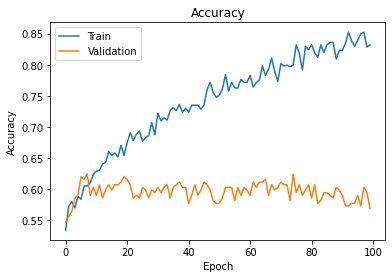

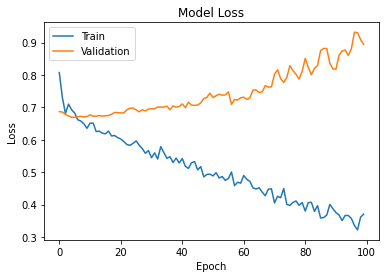

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()

# Plot training and validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()

In [ ]:
accent_prediction= model.predict(x_test)
prediction_accent_rounded = [np.argmax(i) for i in accent_prediction]
# prediction_ANN_rounded[0]
y_test_index = [np.argmax(i) for i in y_test]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_index, prediction_accent_rounded))

              precision    recall  f1-score   support

           0       0.56      0.61      0.58       116
           1       0.58      0.53      0.55       118

    accuracy                           0.57       234
   macro avg       0.57      0.57      0.57       234
weighted avg       0.57      0.57      0.57       234



Text(87.0, 0.5, 'True_value')

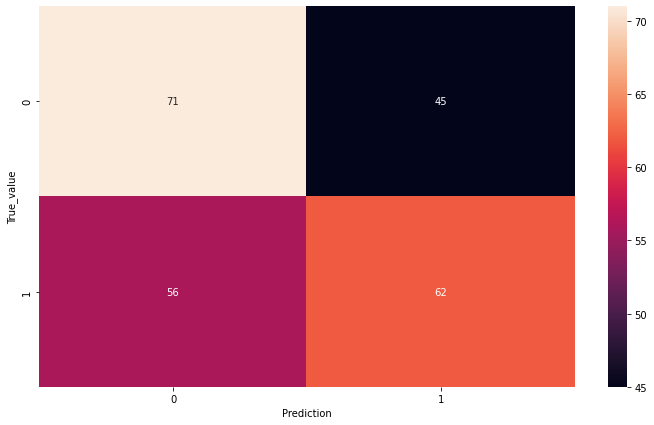

In [ ]:
import tensorflow as tf

#Confusion Matrix - verify accuracy of each class
import seaborn as sns
cm = tf.math.confusion_matrix(labels = y_test_index, predictions = prediction_accent_rounded)
plt.figure(figsize = (12,7))
sns.heatmap(cm,annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True_value')

***LSTM***

In [ ]:
from keras.layers import LSTM,Input
from keras.models import Model

In [ ]:
  model_lstm=Sequential()
  

  model_lstm.add(LSTM(64,return_sequences=True,input_shape=(40,1)))
  model_lstm.add(LSTM(64))
  model_lstm.add(Dense(64,activation='relu',name='Hidden_1'))

  model_lstm.add(Dropout(0.5))

  model_lstm.add(Dense(2,activation='sigmoid'))

  

In [ ]:
model_lstm.compile(optimizer='Adam',loss='binary_crossentropy', metrics =['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
num_epochs=100
num_batch_size=32

checkpointer=ModelCheckpoint(filepath='saved_model/accent_recognition.hdf5',
                            verbose=1, save_best_only=True)

start=datetime.now()

history_lstm= model_lstm.fit(x_train,y_train,batch_size=num_batch_size,epochs=num_epochs,
         validation_data=(x_val,y_val),callbacks=[checkpointer])


duration=datetime.now() - start
print('training completed in time: ', duration)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4798
Epoch 1: val_loss improved from inf to 0.68888, saving model to saved_model/accent_recognition.hdf5
25/25 [==============================] - 8s 150ms/step - loss: 0.6932 - accuracy: 0.4798 - val_loss: 0.6889 - val_accuracy: 0.5143
Epoch 2/100
24/25 [===========================>..] - ETA: 0s - loss: 0.6911 - accuracy: 0.5169
Epoch 2: val_loss did not improve from 0.68888
25/25 [==============================] - 1s 50ms/step - loss: 0.6912 - accuracy: 0.5164 - val_loss: 0.6893 - val_accuracy: 0.5286
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.5770
Epoch 3: val_loss improved from 0.68888 to 0.68638, saving model to saved_model/accent_recognition.hdf5
25/25 [==============================] - 1s 50ms/step - loss: 0.6873 - accuracy: 0.5770 - val_loss: 0.6864 - val_accuracy: 0.5429
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 0.68

In [ ]:
test_accuracy_lstm=model_lstm.evaluate(x_test,y_test,verbose=0)
print(test_accuracy_lstm[1])

0.5299145579338074


In [ ]:
filename="recordings/amazigh1.mp3"
audio, sample_rate= librosa.load(filename, res_type='kaiser_fast')
mfccs_features= librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features=np.mean(mfccs_features.T, axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=np.argmax(model_lstm.predict(mfccs_scaled_features))
print(predicted_label)
prediction_class=labelencoder.inverse_transform(predicted_label.reshape(1))
print("predicted class is: ", prediction_class)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[-3.6791742e+02  1.0162896e+02  1.4820839e+01  2.0737825e+01
  2.6403830e+00  9.5264454e+00 -7.0347967e+00 -2.8898406e-01
 -3.0236263e+00 -7.9882865e+00 -1.0074003e+01 -7.3483977e+00
 -3.9282256e-01 -5.3120160e+00 -1.0301460e+00 -2.6838274e+00
 -2.6456003e+00 -9.8572463e-01  4.9110085e-02 -3.0229642e+00
 -2.6555886e+00 -1.8681757e+00 -4.7854953e+00 -1.9574343e+00
 -1.8222500e+00 -2.1999941e+00 -1.4689418e+00 -2.0138216e+00
 -2.0192835e+00 -2.7389336e+00 -2.4636352e+00 -1.1149848e+00
 -3.8698049e+00 -1.9787462e+00 -1.7506309e+00 -3.4099801e+00
 -1.5978570e+00 -1.6085216e+00 -1.1609491e+00 -2.0533099e+00]
[[-3.6791742e+02  1.0162896e+02  1.4820839e+01  2.0737825e+01
   2.6403830e+00  9.5264454e+00 -7.0347967e+00 -2.8898406e-01
  -3.0236263e+00 -7.9882865e+00 -1.0074003e+01 -7.3483977e+00
  -3.9282256e-01 -5.3120160e+00 -1.0301460e+00 -2.6838274e+00
  -2.6456003e+00 -9.8572463e-01  4.9110085e-02 -3.0229642e+00
  -2.6555886e+00 -1.8681757e+00 -4.7854953e+00 -1.9574343e+00
  -1.8222500e+00 

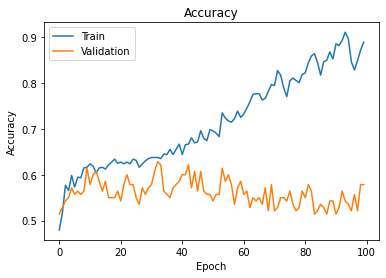

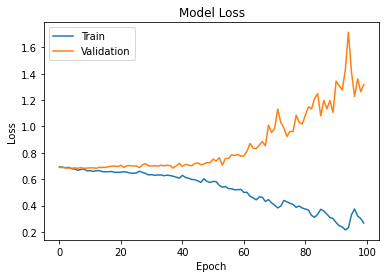

In [ ]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])

plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()

# Plot training and validation accuracy values
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc = 'upper left')
plt.show()

In [ ]:
accent_prediction_lstm= model_lstm.predict(x_test)
prediction_accent_lstm = [np.argmax(i) for i in accent_prediction_lstm]

y_test_index_lstm = [np.argmax(i) for i in y_test]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_index_lstm, prediction_accent_lstm))

              precision    recall  f1-score   support

           0       0.52      0.61      0.56       116
           1       0.54      0.45      0.49       118

    accuracy                           0.53       234
   macro avg       0.53      0.53      0.53       234
weighted avg       0.53      0.53      0.53       234



Text(87.0, 0.5, 'True_value')

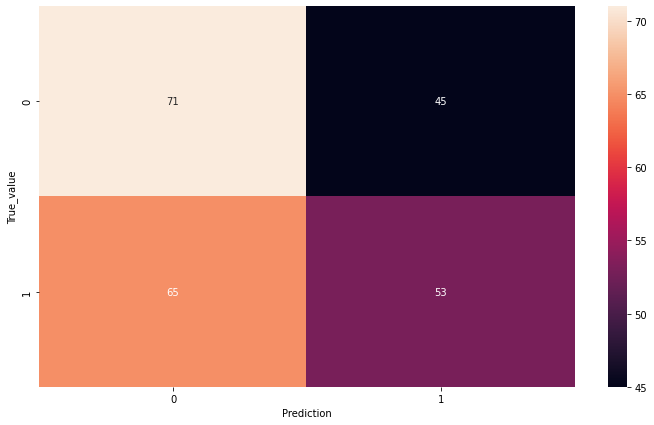

In [ ]:
import tensorflow as tf

#Confusion Matrix - verify accuracy of each class
import seaborn as sns
cm = tf.math.confusion_matrix(labels = y_test_index_lstm, predictions = prediction_accent_lstm)
plt.figure(figsize = (12,7))
sns.heatmap(cm,annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True_value')

In [ ]:

model.save("model.h5")

In [ ]:
model_lstm.save("model_lstm.h5")
